In [1]:
import os
import sys

import matplotlib.pyplot as plt
import pandas as pd
from sklearnex import patch_sklearn

patch_sklearn()

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from keras import regularizers
from keras import layers
from keras.models import Sequential
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, f1_score, precision_score,
                             recall_score)
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from keras.optimizers import Adam

sys.path.insert(0, "\\".join(os.path.abspath(os.curdir).split("\\")[:-2:]))
from src.utils.utils import plot_history

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Detecção câncer de mama

### Importação

In [2]:
SELECTED_DATABASE = "mias"

try:
    breast_cancer_df = pd.read_csv(
        f"../../outputs/mamografia/{SELECTED_DATABASE}/first_order_features_{SELECTED_DATABASE}.csv"
    )
    aux = pd.read_csv(f"../../outputs/mamografia/{SELECTED_DATABASE}/glcm_features_{SELECTED_DATABASE}.csv")
    breast_cancer_df = pd.concat([breast_cancer_df.drop(columns='pathology'), aux], axis=1)
except FileNotFoundError:
    raise Exception("Database not found!")

breast_cancer_df.head()

,mean,std,smoothness,third_moment,uniformity,entropy,dissimilarity_dist_1_ang_0,dissimilarity_dist_1_ang_45,dissimilarity_dist_1_ang_90,dissimilarity_dist_1_ang_135,...,contrast_dist_1_ang_135,energy_dist_1_ang_0,energy_dist_1_ang_45,energy_dist_1_ang_90,energy_dist_1_ang_135,ASM_dist_1_ang_0,ASM_dist_1_ang_45,ASM_dist_1_ang_90,ASM_dist_1_ang_135,pathology
0,53.165596,70.946720,0.999801,383405.10000,0.198968,5.128622,0.839476,1.168157,0.715020,1.017771,...,12.201909,0.440639,0.440191,0.443288,0.440096,0.194163,0.193768,0.196504,0.193684,benign
1,142.088010,80.487860,0.999846,-356561.80000,0.011862,7.157489,1.527602,2.166387,1.521884,1.950162,...,10.975696,0.077866,0.074193,0.079734,0.075127,0.006063,0.005505,0.006357,0.005644,benign
2,145.798920,19.070507,0.997258,-1013.78723,0.014897,6.235056,1.991038,3.529173,2.321602,2.200961,...,9.659911,0.044591,0.033496,0.042059,0.042025,0.001988,0.001122,0.001769,0.001766,benign
3,145.798920,19.070507,0.997258,-1013.78723,0.014897,6.235056,1.991038,3.529173,2.321602,2.200961,...,9.659911,0.044591,0.033496,0.042059,0.042025,0.001988,0.001122,0.001769,0.001766,benign
4,186.046080,14.392229,0.995195,1887.18880,0.022627,5.754518,1.603516,2.270905,1.931703,2.540528,...,12.367694,0.063354,0.052617,0.058984,0.048887,0.004014,0.002769,0.003479,0.002390,benign


In [3]:
print(breast_cancer_df['pathology'].value_counts())

samples_benign = breast_cancer_df[breast_cancer_df['pathology'] == 'benign'].sample(5, random_state=42, replace=True)
samples_malign = breast_cancer_df[breast_cancer_df['pathology'] == 'malignant'].sample(2, random_state=42, replace=True)

breast_cancer_df = pd.concat([breast_cancer_df, samples_benign, samples_malign]).reset_index(drop=True)

breast_cancer_df['pathology'].value_counts()

benign       68
malignant    51
Name: pathology, dtype: int64


benign       73
malignant    53
Name: pathology, dtype: int64

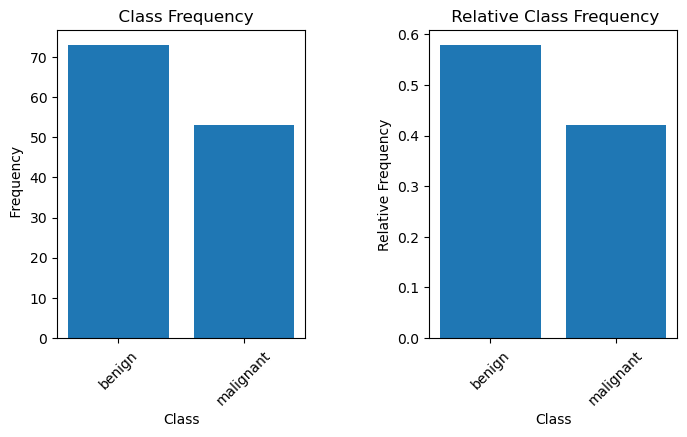

In [4]:
fig = plt.figure(figsize=(8, 4))
titles = ['', 'Relative']

for i, title in enumerate(titles, start=1):
    isRelative = True if i == 2 else False
    frequency = breast_cancer_df['pathology'].value_counts(normalize=isRelative)
    plt.subplot(1, 2, i)
    plt.bar(frequency.index, frequency)
    plt.title(f' {title} Class Frequency')
    plt.xlabel('Class'), plt.ylabel(f'{title} Frequency')
    plt.xticks(rotation=45)
fig.subplots_adjust(wspace=0.5)
plt.show()

### Pré-Processamento

In [5]:
# Elimina os dados com classe BENIGN_WITHOUT_CALLBACK ou NORMAL
breast_cancer_df = breast_cancer_df[breast_cancer_df["pathology"] != "benign_without_callback"]
breast_cancer_df = breast_cancer_df[breast_cancer_df["pathology"] != "normal"]

# Elimina os dados com valores nulos
breast_cancer_df.dropna(inplace=True)

# Separa em features e labels
X, y = (breast_cancer_df.drop(["pathology"], axis=1), breast_cancer_df["pathology"])

# Tratamos os rótulos categóricos
y = y.map({"benign": 0, "malignant": 1})

# Separa os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Balanceamento dos dados
""" if SELECTED_DATABASE in ["inbreast", "mias"]:
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)
elif SELECTED_DATABASE in ["cmmd"]:
    random_under_sampler = RandomUnderSampler()
    X_train, y_train = random_under_sampler.fit_resample(X_train, y_train) """

# Reduz a dimensionalidade
pca = PCA(n_components=5, random_state=42)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

# Padroniza os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Treinamento dos modelos

In [6]:
def create_mlp_model(shape):
    model = Sequential()
    model.add(layers.Dense(24, input_dim=shape, kernel_regularizer=regularizers.L1(0.007)))
    model.add(layers.Activation("relu"))
    model.add(layers.Dropout(0.3))

    #model.add(layers.Dense(24))
    #model.add(layers.Activation("relu"))
    #model.add(layers.Dropout(0.3))

    model.add(layers.Dense(1))
    model.add(layers.Activation("sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.0005), metrics=["accuracy"])
    return model

In [7]:
epochs = 300
batch_size = 4
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.20)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = {"Random Forest": [], "KNN": [], "MLP": []}
train_scores = {"Random Forest": [], "KNN": [], "MLP": []}
history = None

# bests { neurons: 24, layers: 1, dropout: 0.3, l1: 0.001, learning_rate: 0.0005, epochs: 300, batch_size: 4 }
y_train = y_train.to_numpy()

for train_index, valid_index in kf.split(X_train):
    X_train_cv, X_valid_cv = X_train[train_index], X_train[valid_index]
    y_train_cv, y_valid_cv = y_train[train_index], y_train[valid_index]

    random_forest_model = RandomForestClassifier(bootstrap=True, class_weight='balanced',
                                                criterion='entropy', max_depth=8,
                                                max_features='sqrt', n_estimators=70,
                                                min_samples_split=3, min_samples_leaf=2,
                                                n_jobs=-1)

    knn_model = KNeighborsClassifier(algorithm='auto', leaf_size=10, n_neighbors=15, p=1, weights='distance')

    mlp_model = create_mlp_model(X_train.shape[1])

    models_names = ["Random Forest", "KNN", "MLP"]
    models = [random_forest_model, knn_model, mlp_model]

    for model, name in zip(models, models_names):
        if name == "MLP":
            history = model.fit(X_train_cv, y_train_cv, epochs=epochs, batch_size=batch_size, verbose=None,
                                validation_data=(X_valid_cv, y_valid_cv))
            y_train_pred = model.predict(X_train_cv)
            y_valid_pred = model.predict(X_valid_cv)

            y_valid_pred = (y_valid_pred > 0.5).astype(int)
            y_train_pred = (y_train_pred > 0.5).astype(int)

            valid_accuracy = accuracy_score(y_valid_cv, y_valid_pred)
            train_accuracy = accuracy_score(y_train_cv, y_train_pred)

            scores[name].append(valid_accuracy)
            train_scores[name].append(train_accuracy)
            continue

        model.fit(X_train_cv, y_train_cv)
        y_valid_pred = model.predict(X_valid_cv)
        y_train_pred = model.predict(X_train_cv)

        train_accuracy = accuracy_score(y_train_cv, y_train_pred)
        valid_accuracy = accuracy_score(y_valid_cv, y_valid_pred)

        scores[name].append(valid_accuracy)
        train_scores[name].append(train_accuracy)

for name in models_names:
    print(f"Train {name}: {sum(train_scores[name])/len(train_scores[name])}")
    print(f"Valid {name}: {sum(scores[name])/len(scores[name])}\n")

# plot_history(history)

1/1 [==============================] - 0s 20ms/step
Train Random Forest: 0.9800000000000001
Valid Random Forest: 0.59

Train KNN: 0.9925
Valid KNN: 0.6100000000000001

Train MLP: 0.7150000000000001
Valid MLP: 0.6399999999999999



In [8]:
""" # Models
random_forest_model = RandomForestClassifier(bootstrap=True, class_weight='balanced',
                                             criterion='entropy', max_depth=8,
                                             max_features='sqrt', n_estimators=70,
                                             min_samples_split=3, min_samples_leaf=2,
                                             n_jobs=-1)

knn_model = KNeighborsClassifier(algorithm='auto', leaf_size=10, n_neighbors=15, p=1, weights='distance')

mlp_model = create_mlp_model(X_train.shape[1])

threshold = 0.5
titles = ["Random Forest", "KNN", "MLP"]
models = [random_forest_model, knn_model, mlp_model]
scores = {}

for model, title in zip(models, titles):
    predict = []
    if title == "MLP":
        model.fit(X_train, y_train, epochs=100, batch_size=4, verbose=0)
        predict = model.predict(X_test)
        predict = (predict > threshold).astype(int) # Transformar as saídas em rótulos
    else:
        model.fit(X_train, y_train)
        predict = model.predict(X_test)

    scores[title] = {"accuracy_score": accuracy_score(y_test, predict) * 100}
    scores[title]["precision_score"] = precision_score(y_test, predict) * 100
    scores[title]["recall_score"] = recall_score(y_test, predict) * 100
    scores[title]["f1_score"] = f1_score(y_test, predict) * 100 """

' # Models\nrandom_forest_model = RandomForestClassifier(bootstrap=True, class_weight=\'balanced\',\n                                             criterion=\'entropy\', max_depth=8,\n                                             max_features=\'sqrt\', n_estimators=70,\n                                             min_samples_split=3, min_samples_leaf=2,\n                                             n_jobs=-1)\n\nknn_model = KNeighborsClassifier(algorithm=\'auto\', leaf_size=10, n_neighbors=15, p=1, weights=\'distance\')\n\nmlp_model = create_mlp_model(X_train.shape[1])\n\nthreshold = 0.5\ntitles = ["Random Forest", "KNN", "MLP"]\nmodels = [random_forest_model, knn_model, mlp_model]\nscores = {}\n\nfor model, title in zip(models, titles):\n    predict = []\n    if title == "MLP":\n        model.fit(X_train, y_train, epochs=100, batch_size=4, verbose=0)\n        predict = model.predict(X_test)\n        predict = (predict > threshold).astype(int) # Transformar as saídas em rótulos\n    els

### Avaliação dos modelos

In [9]:
# scores_df = pd.DataFrame(scores).T
# scores_df

In [11]:
result = [[0.6, 0.610000, 0.56],
[0.6, 0.61000, 0.6],
[0.6399999999999999, 0.61000, 0.60],
[0.6399999999999999, 0.6100000000000001, 0.6100000000000001],
[0.59, 0.61, 0.63999]]
columns=['Random Forest', 'KNN', 'MLP']
df = pd.DataFrame(result, columns=columns)

def mean_without_extremes(df):
    new_df = pd.DataFrame(columns=df.columns)
    for col in df.columns:
        df.sort_values(by=col, inplace=True)
        df[col] = df[col].drop(df[col].index[[0, -1]])
        new_df[col] = [df[col].mean() * 100]
    return new_df

df = mean_without_extremes(df)
df

,Random Forest,KNN,MLP
0,61.333333,61.0,60.333333
